# v3 Update Notes

Version 3 replaces the v2 single-foot peak detection with a dual-foot strike model.  
Both left and right heel signals are now smoothed, analyzed, and used to detect candidate peaks.  
A new iterative N/M search generates evenly spaced, alternating heel strikes and snaps them to real peaks.  
This improves accuracy, handles missing peaks, and enforces realistic left/right alternation.  
Final heel strikes from both feet are used for plotting and video frame extraction.

In [1]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import os
import cv2

In [2]:
subject_number = 118
view = "side"
input_file = f"./input/mediapipe/{subject_number}/{subject_number}_{view}_landmarks.json"
video_file = f"./input/mediapipe/{subject_number}/{subject_number}_{view}_pose.mp4"
outputdir = f"./output/{subject_number}"
output_file = f"./output/{subject_number}/{subject_number}_{view}_2_gait_cycles.json"
screenshots_dir = f"./output/{subject_number}/{view}_heel_strike_screenshots"

fps = 30.0
dt = 1.0 / fps

landmarks = {
    0: "Nose", 1: "Left_Eye_Inner", 2: "Left_Eye", 3: "Left_Eye_Outer",
    4: "Right_Eye_Inner", 5: "Right_Eye", 6: "Right_Eye_Outer",
    7: "Left_Ear", 8: "Right_Ear", 9: "Mouth_Left", 10: "Mouth_Right",
    11: "Left_Shoulder", 12: "Right_Shoulder", 13: "Left_Elbow", 14: "Right_Elbow",
    15: "Left_Wrist", 16: "Right_Wrist", 17: "Left_Pinky", 18: "Right_Pinky",
    19: "Left_Index", 20: "Right_Index", 21: "Left_Thumb", 22: "Right_Thumb",
    23: "Left_Hip", 24: "Right_Hip", 25: "Left_Knee", 26: "Right_Knee",
    27: "Left_Ankle", 28: "Right_Ankle", 29: "Left_Heel", 30: "Right_Heel",
    31: "Left_Foot_Index", 32: "Right_Foot_Index"
}

landmark_index = 30
landmark_name = landmarks[landmark_index]

os.makedirs(outputdir, exist_ok=True)
os.makedirs(screenshots_dir, exist_ok=True)

# Clear old screenshots from screenshots dir
for f in os.listdir(screenshots_dir):
    path = os.path.join(screenshots_dir, f)
    if os.path.isfile(path):
        os.remove(path)

In [3]:
# Load and rewrite files to exclude none and null values
with open(input_file, "r") as f:
    data = json.load(f)

data['landmarks_data'] = [
    frame for frame in data['landmarks_data']
    if (frame['pose_landmarks'] is not None)
]

In [4]:
# Load mediapipe data
with open(input_file, "r") as f:
    data = json.load(f)   
    
frames = data["landmarks_data"]
points = []
for frame in frames:
    if "pose_landmarks" in frame and frame["pose_landmarks"]:
        arr = np.array(frame["pose_landmarks"])[:, :3]
        points.append(arr)
    else:
        points.append(None)

In [5]:
def smooth_pose_butter(poses, cutoff=3, fs=30, order=4):
    """
    cutoff: cutoff frequency (Hz)
    fs: sample rate (frames per second)
    order: filter order
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='low')
    smoothed = np.copy(poses)
    for j in range(poses.shape[1]):
        for k in range(3):
            smoothed[:, j, k] = filtfilt(b, a, poses[:, j, k])
    return smoothed

In [6]:
points = np.array(points)
points = smooth_pose_butter(points, fs=fps, order=4)

# Compute time
time = np.arange(points.shape[0]) / fps

In [ ]:
# Left heel velocity calculation (landmark 29)
left_heel_velocity = []
for i in range(len(points) - 1):
    p1 = points[i][29]
    p2 = points[i + 1][29]
    d = math.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2) + ((p2[2] - p1[2]) ** 2))
    left_heel_velocity.append(d)

# Right heel velocity calculation (landmark 30)
right_heel_velocity = []
for i in range(len(points) - 1):
    p1 = points[i][30]
    p2 = points[i + 1][30]
    d = math.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2) + ((p2[2] - p1[2]) ** 2))
    right_heel_velocity.append(d)

# Compute acceleration from velocity
left_heel_acceleration = np.gradient(left_heel_velocity, dt)
right_heel_acceleration = np.gradient(right_heel_velocity, dt)

# Smooth the acceleration signals
left_heel_acceleration_smooth = gaussian_filter1d(left_heel_acceleration, sigma=8)
right_heel_acceleration_smooth = gaussian_filter1d(right_heel_acceleration, sigma=8)

# Also compute velocity smooth for reference
left_heel_velocity_smooth = gaussian_filter1d(left_heel_velocity, sigma=8)
right_heel_velocity_smooth = gaussian_filter1d(right_heel_velocity, sigma=8)

# Adjust time array to match acceleration length 
time_accel = time[:len(left_heel_acceleration)]

In [8]:
# Candidate peak detection for both feet using accleration signal 

height_right = abs(np.percentile(right_heel_acceleration_smooth, 25))
height_left = abs(np.percentile(left_heel_acceleration_smooth, 25))

print(f"Using height threshold for right heel: {height_right}")
print(f"Using height threshold for left heel: {height_left}")

# Find valleys in acceleration (heel strikes)
right_heel_candidates, _ = find_peaks(
    -right_heel_acceleration_smooth,
    height=height_right,
    distance=5
)

left_heel_candidates, _ = find_peaks(
    -left_heel_acceleration_smooth,
    height=height_left,
    distance=5
)

print(f"\nRaw right heel candidates: {len(right_heel_candidates)}")
print("Indices (right):", right_heel_candidates)
print(f"Raw left heel candidates: {len(left_heel_candidates)}")
print("Indices (left):", left_heel_candidates)

Using height threshold for right heel: 0.005776670799453596
Using height threshold for left heel: 0.006599546408496378

Raw right heel candidates: 14
Indices (right): [ 39  67  94 127 158 187 213 284 308 365 395 425 456 486]
Raw left heel candidates: 14
Indices (left): [ 15  52  79 133 172 202 226 262 295 323 370 412 437 485]


In [9]:
# # Estimate Center of Mass velocity & trunk yaw for trimming / masking
# left_hip = points[:, 23, :]
# right_hip = points[:, 24, :]
# hip_center = (left_hip + right_hip) / 2.0

# # Hip velocity magnitude
# hip_vel = np.linalg.norm(np.diff(hip_center, axis=0), axis=1) / dt
# hip_vel_smooth = gaussian_filter1d(hip_vel, sigma=4)


# # Shoulder vector to estimate body yaw
# left_shoulder = points[:, 11, :]
# right_shoulder = points[:, 12, :]
# shoulder_vec = right_shoulder - left_shoulder

# # Yaw angle: rotation around vertical axis using x-z plane
# yaw = np.arctan2(shoulder_vec[:, 2], shoulder_vec[:, 0])
# yaw_diff = np.diff(yaw)
# yaw_diff = np.unwrap(yaw_diff)
# yaw_vel = np.abs(yaw_diff) / dt

# hip_vel_padded = np.concatenate([[hip_vel_smooth[0]], hip_vel_smooth])
# yaw_vel_padded = np.concatenate([[yaw_vel[0]], yaw_vel])

# # Thresholds for yaw and hip which invalid heel strikes
# hip_vel_threshold = max(0.015, np.percentile(hip_vel_smooth, 5))
# yaw_vel_threshold = np.deg2rad(60)

# print(f"Using hip_vel_threshold: {hip_vel_threshold}")
# print(f"Using yaw_vel_threshold (degs/s): {np.rad2deg(yaw_vel_threshold)}")

# is_moving = hip_vel_padded > hip_vel_threshold
# is_turning = yaw_vel_padded > yaw_vel_threshold

# # Boolean mask: subject is moving and not turning
# valid_gait_mask = is_moving & (~is_turning)

In [10]:
# # Filter candidate peaks by the gait mask
# filtered_right_candidates = np.array([
#     idx for idx in right_heel_candidates
#     if 0 <= idx < len(valid_gait_mask) and valid_gait_mask[idx]
# ])

# filtered_left_candidates = np.array([
#     idx for idx in left_heel_candidates
#     if 0 <= idx < len(valid_gait_mask) and valid_gait_mask[idx]
# ])

# print(f"Filtered right heel candidates: {len(filtered_right_candidates)}")
# print("Indices (right, filtered):", filtered_right_candidates)
# print(f"Filtered left heel candidates: {len(filtered_left_candidates)}")
# print("Indices (left, filtered):", filtered_left_candidates)

In [11]:
# Iterative N/M search for evenly spaced, alternating L/R heel strikes
def compute_pattern_score(ideal_strikes, real_right, real_left):
    """
    ideal_strikes: list of (frame_idx, 'R' or 'L')
    real_right, real_left: np.array of candidate peak frame indices
    Returns:
      score (float), snapped_right (list of frames), snapped_left (list of frames)
    """
    # Make sure both sides have candidates
    if len(real_right) == 0 and any(side == 'R' for _, side in ideal_strikes):
        return float('inf'), [], []
    if len(real_left) == 0 and any(side == 'L' for _, side in ideal_strikes):
        return float('inf'), [], []

    used_r = set()
    used_l = set()
    snapped_right = []
    snapped_left = []
    total_sq_error = 0.0

    for ideal_frame, side in ideal_strikes:
        if side == 'R':
            if len(real_right) == 0:
                return float('inf'), [], []
            # Find nearest unused right peak
            available = [i for i in range(len(real_right)) if i not in used_r]
            if not available:
                return float('inf'), [], []
            diffs = [abs(real_right[i] - ideal_frame) for i in available]
            best_idx_local = available[int(np.argmin(diffs))]
            best_frame = real_right[best_idx_local]
            used_r.add(best_idx_local)
            snapped_right.append(best_frame)
            total_sq_error += (best_frame - ideal_frame) ** 2
        else:  # 'L'
            if len(real_left) == 0:
                return float('inf'), [], []
            available = [i for i in range(len(real_left)) if i not in used_l]
            if not available:
                return float('inf'), [], []
            diffs = [abs(real_left[i] - ideal_frame) for i in available]
            best_idx_local = available[int(np.argmin(diffs))]
            best_frame = real_left[best_idx_local]
            used_l.add(best_idx_local)
            snapped_left.append(best_frame)
            total_sq_error += (best_frame - ideal_frame) ** 2

    n_strikes = len(ideal_strikes)
    if n_strikes == 0:
        return float('inf'), [], []

    # Base score: mean squared time error
    base_score = total_sq_error / n_strikes

    # Even spacing penalty (cadence consistency)
    all_snapped = sorted(snapped_right + snapped_left)
    if len(all_snapped) > 2:
        intervals = np.diff(all_snapped)
        spacing_var = np.var(intervals)
    else:
        spacing_var = 0.0

    spacing_penalty_weight = 0.1
    
    # Penalize too few strikes
    strike_count_penalty = 1.0 / (len(ideal_strikes) + 1e-6)

    score = base_score \
            + spacing_penalty_weight * spacing_var \
            + 0.5 * strike_count_penalty
    return score, snapped_right, snapped_left

In [12]:
def find_best_strike_pattern(
    segment_start,
    segment_end,
    real_right_peaks,
    real_left_peaks,
    min_steps_per_side=4,
    max_steps_per_side=25,
    global_min_step_frames=5,
    global_max_step_frames=100
):
    """
    NEW VERSION:
    Fits N evenly spaced strikes *independently* for each foot.
    No strict alternation. No forced pairing.

    For each foot:
      1. Try N = 4..25 ideal strikes
      2. Compute ideal spacing across the segment
      3. Snap each ideal strike to the nearest real peak
      4. Score based on dt^2 + cadence variance

    Final output:
      - best_right: snapped matches for right foot
      - best_left: snapped matches for left foot
    """

    # Filter peaks to this segment
    real_right = real_right_peaks[
        (real_right_peaks >= segment_start) & (real_right_peaks <= segment_end)
    ]
    real_left  = real_left_peaks[
        (real_left_peaks >= segment_start) & (real_left_peaks <= segment_end)
    ]

    segment_len = segment_end - segment_start + 1

    # If no real peaks on a foot, return empty
    if len(real_right) == 0:
        best_right = []
    if len(real_left) == 0:
        best_left = []

    # score an ideal sequence
    def score_foot(real_peaks, N):

        if N < 2 or len(real_peaks) == 0:
            return float('inf'), []

        avg_step = segment_len / N

        # Step times to try
        step_times = range(
            max(global_min_step_frames, int(avg_step * 0.7)),
            min(global_max_step_frames, int(avg_step * 1.3)) + 1
        )

        best_score = float('inf')
        best_snapped = []
        best_ideal = []

        for st in step_times:
            for phase in range(st):

                # Build N ideal strike times
                ideal = []
                t = segment_start + phase
                while t <= segment_end and len(ideal) < N:
                    ideal.append(t)
                    t += st

                if len(ideal) != N:
                    continue

                # Snap to real peaks
                snapped = []
                errors = []
                used = set()

                for ide in ideal:
                    # nearest unused real peak
                    diffs = np.abs(real_peaks - ide)
                    order = np.argsort(diffs)

                    picked = None
                    for idx in order:
                        if idx not in used:
                            picked = real_peaks[idx]
                            used.add(idx)
                            snapped.append(picked)
                            errors.append((picked - ide)**2)
                            break

                    # If all used, pattern impossible
                    if picked is None:
                        errors.append((segment_len)**2)

                if len(errors) == 0:
                    continue

                mse = np.mean(errors)

                snapped_sorted = sorted(snapped)
                if len(snapped_sorted) > 2:
                    iv = np.var(np.diff(snapped_sorted))
                else:
                    iv = 0

                score = mse + 0.1 * iv

                # Penalty for very small strike counts
                strike_penalty = 0.5 / (N + 1e-6)
                score += strike_penalty

            if score < best_score:
                best_score = score
                best_snapped = snapped_sorted
                best_ideal = ideal

        return best_score, best_snapped, best_ideal

    # Fit right and left separately
    best_right_score = float('inf')
    best_right = []

    for N in range(min_steps_per_side, max_steps_per_side + 1):
        score, snapped, ideal = score_foot(real_right, N)
        if score < best_right_score:
            best_right_score = score
            best_right = snapped
            best_ideal_right = ideal

    best_left_score = float('inf')
    best_left = []

    for N in range(min_steps_per_side, max_steps_per_side + 1):
        score, snapped, ideal = score_foot(real_left, N)
        if score < best_left_score:
            best_left_score = score
            best_left = snapped
            best_ideal_left = ideal

    return best_right, best_left, best_ideal_right, best_ideal_left


In [13]:
def compute_strike_confidence(ideal_frames, snapped_frames, real_peaks):
    """
    Confidence is based on:
      - distance to nearest real peak (smaller = better)
      - consistency of spacing
      - local peak prominence
    
    Returns:
        confidences: list of floats, same length as snapped_frames
    """

    confidences = []

    # Basic normalization terms
    max_dt = 80   # frames
    max_prom = 0.02  # typical heel_y range
    
    for i, sf in enumerate(snapped_frames):

        # 1. Distance score (the core signal)
        dt = abs(sf - ideal_frames[i])
        dist_score = 1 - min(dt / max_dt, 1.0)

        # 2. Local prominence score
        if len(real_peaks) > 1:
            idx = np.argmin(np.abs(real_peaks - sf))
            if 0 < idx < len(real_peaks)-1:
                left = real_peaks[idx-1]
                right = real_peaks[idx+1]
                local_range = right - left
                prominence_score = 1 - min(local_range / 150, 1.0)
            else:
                prominence_score = 0.6
        else:
            prominence_score = 0.5

        # 3. Combine
        conf = 0.6 * dist_score + 0.4 * prominence_score
        confidences.append(conf)

    return confidences

In [14]:
segment_start = 0
segment_end = len(left_heel_acceleration) - 1

final_right_strikes, final_left_strikes, ideal_right_strikes, ideal_left_strikes = find_best_strike_pattern(
    segment_start,
    segment_end,
    right_heel_candidates,
    left_heel_candidates,
    min_steps_per_side=4,
    max_steps_per_side=25,
    global_min_step_frames=5,
    global_max_step_frames=100
)

print("\n=== Final model-fitted heel strikes ===")
print(f"Right strikes ({len(final_right_strikes)}): {final_right_strikes}")
print(f"Left strikes  ({len(final_left_strikes)}): {final_left_strikes}")

# Union of all final strikes (for screenshots, etc.)
all_final_strikes = sorted(final_right_strikes + final_left_strikes)
all_final_strikes = np.array(all_final_strikes, dtype=int)


=== Final model-fitted heel strikes ===
Right strikes (4): [94, 187, 284, 365]
Left strikes  (6): [79, 133, 226, 295, 370, 437]


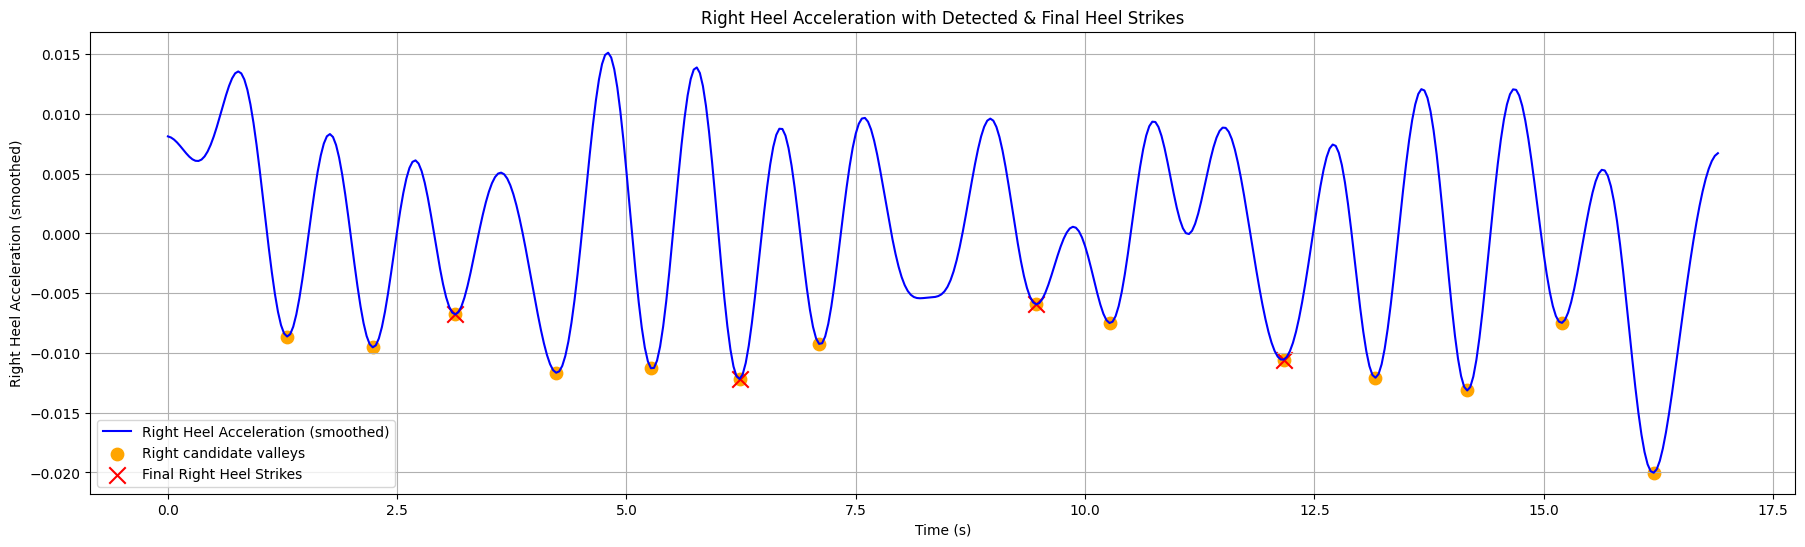

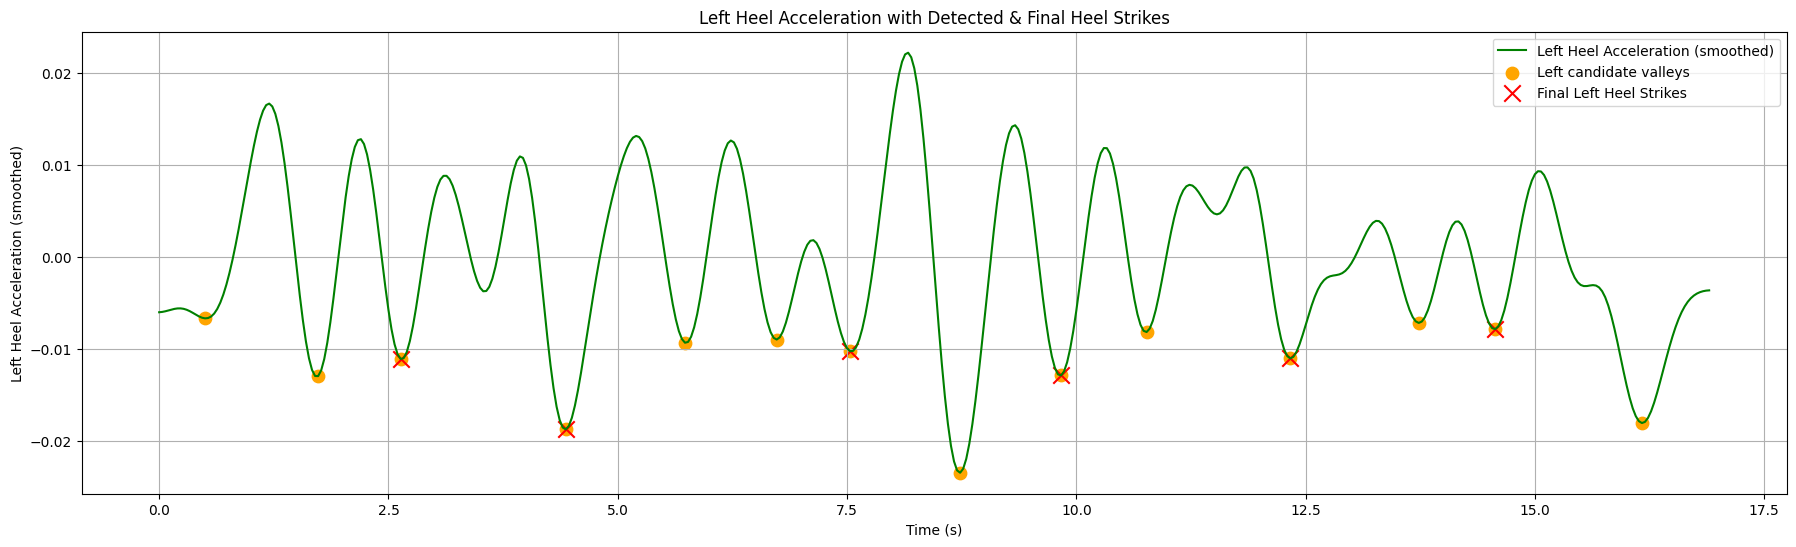

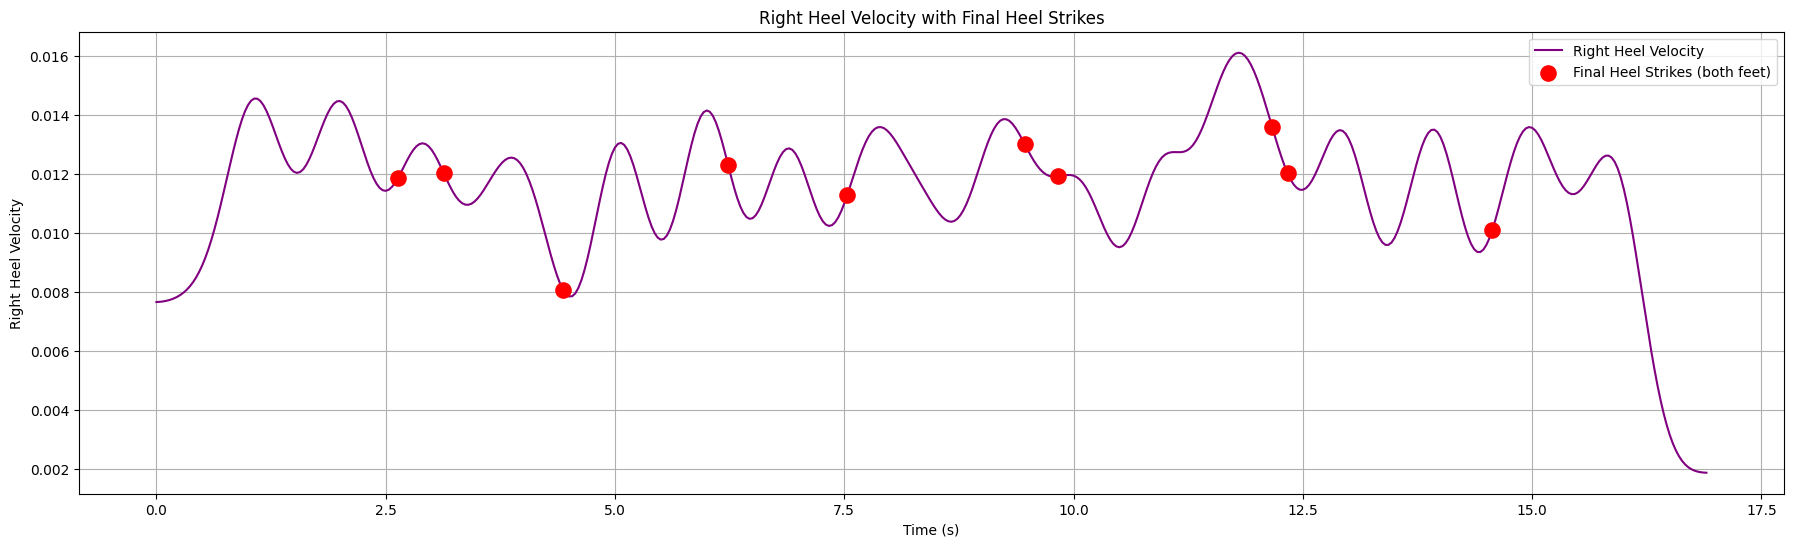

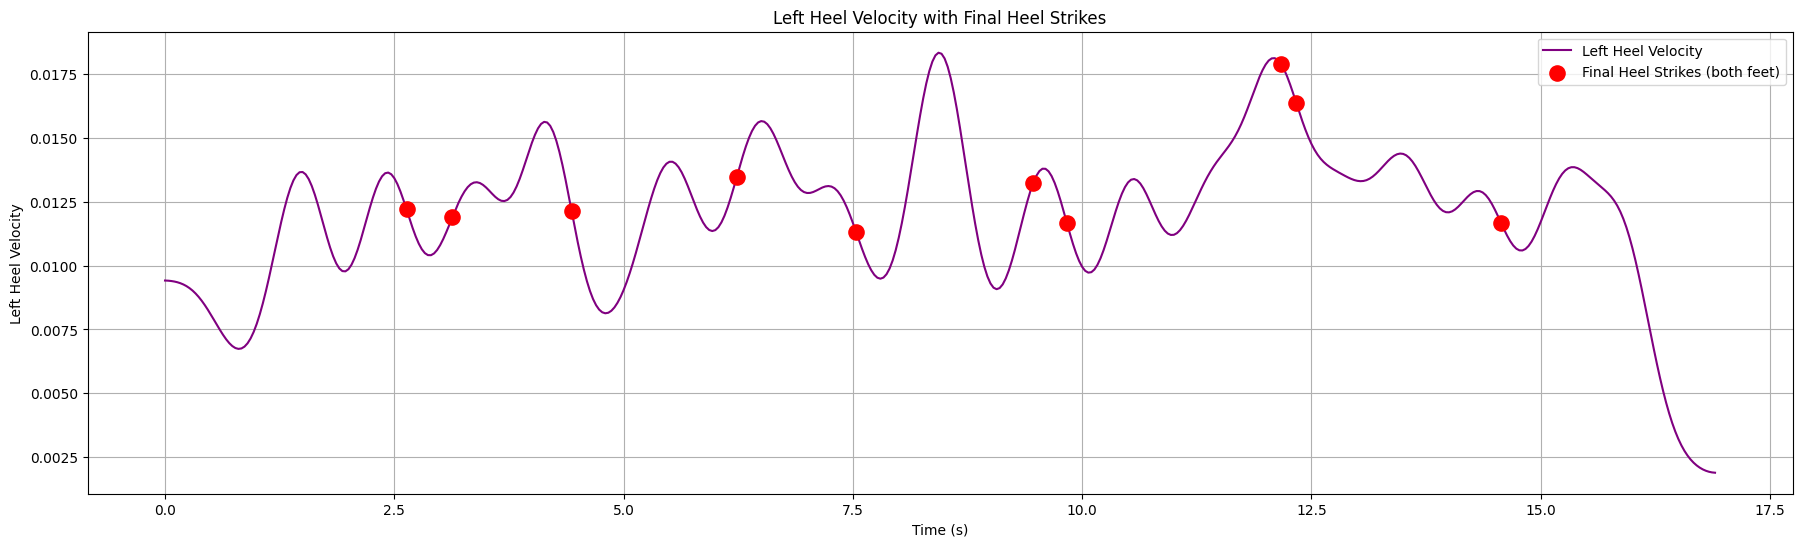

In [15]:
# Plots: acceleration signals + candidate peaks + final strikes

# Right heel strike + final detected
plt.figure(figsize=(22, 6))
plt.plot(time_accel, right_heel_acceleration_smooth, label="Right Heel Acceleration (smoothed)", color='blue')
plt.scatter(time_accel[right_heel_candidates], right_heel_acceleration_smooth[right_heel_candidates],
            color='orange', s=80, label="Right candidate valleys")
plt.scatter(time_accel[final_right_strikes], right_heel_acceleration_smooth[final_right_strikes],
            color='red', s=140, marker='x', label="Final Right Heel Strikes")
plt.title("Right Heel Acceleration with Detected & Final Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Right Heel Acceleration (smoothed)")
plt.grid(True); plt.legend(); plt.show()

# Left heel strike + final deteected
plt.figure(figsize=(22, 6))
plt.plot(time_accel, left_heel_acceleration_smooth, label="Left Heel Acceleration (smoothed)", color='green')
plt.scatter(time_accel[left_heel_candidates], left_heel_acceleration_smooth[left_heel_candidates],
            color='orange', s=80, label="Left candidate valleys")
plt.scatter(time_accel[final_left_strikes], left_heel_acceleration_smooth[final_left_strikes],
            color='red', s=140, marker='x', label="Final Left Heel Strikes")
plt.title("Left Heel Acceleration with Detected & Final Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Left Heel Acceleration (smoothed)")
plt.grid(True); plt.legend(); plt.show()

# Optional velocity plots

# Right heel velocity
plt.figure(figsize=(22, 6))
plt.plot(time_accel, right_heel_velocity_smooth, label="Right Heel Velocity", color='purple')
plt.scatter(time_accel[all_final_strikes], right_heel_velocity_smooth[all_final_strikes],
            color='red', s=120, zorder=5, label="Final Heel Strikes (both feet)")
plt.title("Right Heel Velocity with Final Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Right Heel Velocity")
plt.grid(True); plt.legend(); plt.show()

# Left heel velocity
plt.figure(figsize=(22, 6))
plt.plot(time_accel, left_heel_velocity_smooth, label="Left Heel Velocity", color='purple')
plt.scatter(time_accel[all_final_strikes], left_heel_velocity_smooth[all_final_strikes],
            color='red', s=120, zorder=5, label="Final Heel Strikes (both feet)")
plt.title("Left Heel Velocity with Final Heel Strikes")
plt.xlabel("Time (s)")
plt.ylabel("Left Heel Velocity")
plt.grid(True); plt.legend(); plt.show()

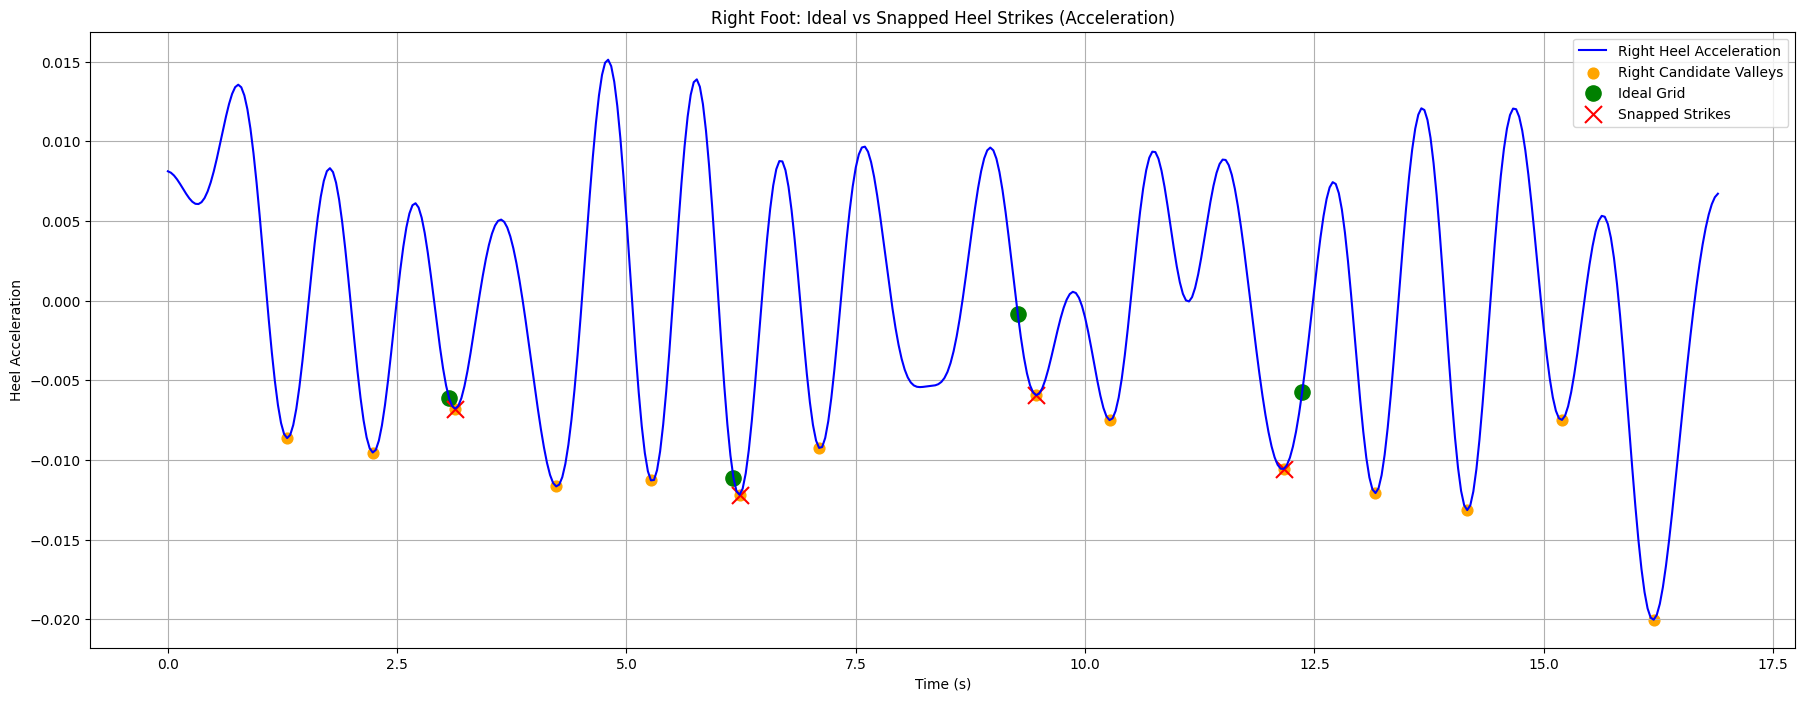

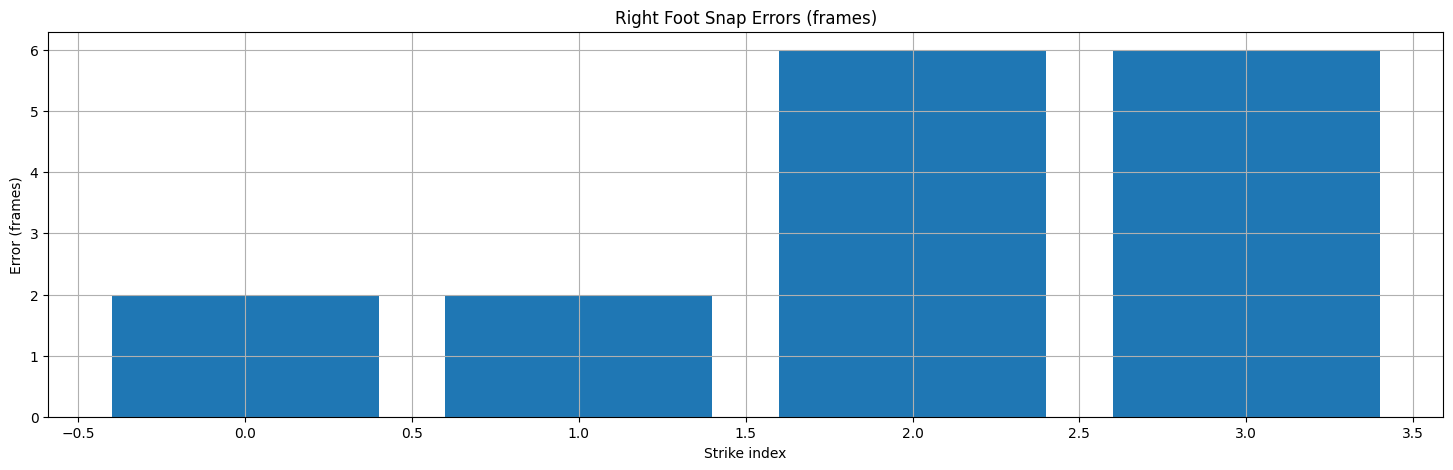

In [16]:
# Debug Visualization: Ideal VS Snapped
plt.figure(figsize=(22, 8))
plt.plot(time_accel, right_heel_acceleration_smooth, label='Right Heel Acceleration', color='blue')

# Real candidate peaks (valleys in acceleration)
plt.scatter(time_accel[right_heel_candidates],
            right_heel_acceleration_smooth[right_heel_candidates],
            color='orange', s=60, label='Right Candidate Valleys')

# Ideal grid
plt.scatter(time_accel[ideal_right_strikes],
            right_heel_acceleration_smooth[ideal_right_strikes],
            color='green', s=120, marker='o', label='Ideal Grid')

# Snapped strikes
plt.scatter(time_accel[final_right_strikes],
            right_heel_acceleration_smooth[final_right_strikes],
            color='red', s=150, marker='x', label='Snapped Strikes')

plt.title("Right Foot: Ideal vs Snapped Heel Strikes (Acceleration)")
plt.xlabel("Time (s)")
plt.ylabel("Heel Acceleration")
plt.grid(True)
plt.legend()
plt.show()


# Debug Error Plot
errors = [abs(a-b) for a,b in zip(ideal_right_strikes, final_right_strikes)]

plt.figure(figsize=(18,5))
plt.bar(range(len(errors)), errors)
plt.title("Right Foot Snap Errors (frames)")
plt.xlabel("Strike index")
plt.ylabel("Error (frames)")
plt.grid(True)
plt.show()

In [17]:
# Print out strike times for inspection
counter = 1
for hs in all_final_strikes:
    print(f"Heel Strike {counter}: frame {hs} at {time_accel[hs]:.3f}s")
    counter += 1

Heel Strike 1: frame 79 at 2.633s
Heel Strike 2: frame 94 at 3.133s
Heel Strike 3: frame 133 at 4.433s
Heel Strike 4: frame 187 at 6.233s
Heel Strike 5: frame 226 at 7.533s
Heel Strike 6: frame 284 at 9.467s
Heel Strike 7: frame 295 at 9.833s
Heel Strike 8: frame 365 at 12.167s
Heel Strike 9: frame 370 at 12.333s
Heel Strike 10: frame 437 at 14.567s


In [18]:
conf_R = compute_strike_confidence(ideal_right_strikes, final_right_strikes, right_heel_candidates)

print("Right foot strike confidence:")
for i, (fr, c) in enumerate(zip(final_right_strikes, conf_R)):
    print(f"  Strike {i+1}: frame {fr}, confidence={c:.2f}")

conf_L = compute_strike_confidence(ideal_left_strikes, final_left_strikes, left_heel_candidates)

print("Left foot strike confidence:")
for i, (fl, c) in enumerate(zip(final_left_strikes, conf_L)):
    print(f"  Strike {i+1}: frame {fl}, confidence={c:.2f}")


Right foot strike confidence:
  Strike 1: frame 94, confidence=0.82
  Strike 2: frame 187, confidence=0.84
  Strike 3: frame 284, confidence=0.70
  Strike 4: frame 365, confidence=0.72
Left foot strike confidence:
  Strike 1: frame 79, confidence=0.74
  Strike 2: frame 133, confidence=0.65
  Strike 3: frame 226, confidence=0.80
  Strike 4: frame 295, confidence=0.84
  Strike 5: frame 370, confidence=0.76
  Strike 6: frame 437, confidence=0.76


In [19]:
# Extract screenshots from video at each final heel strike
print("Extracting video frames at final heel strike timestamps...")

if not os.path.exists(video_file):
    print(f"Error: Video file not found at {video_file}")
else:
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_file}")
    else:
        video_fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        print(f"Video properties:")
        print(f"  - FPS: {video_fps}")
        print(f"  - Total frames: {total_frames}")
        print(f"  - Resolution: {frame_width}x{frame_height}")
        print(f"  - Duration: {total_frames/video_fps:.2f}s\n")

        screenshots_saved = 0
        for i, hs in enumerate(all_final_strikes):
            frame_idx = int(hs)
            timestamp = time_accel[hs]

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()

            if not ret:
                print(f"  Error: Could not read frame {frame_idx}")
                continue

            screenshot_path = (
                f"{screenshots_dir}/heel_strike_{i+1:02d}_"
                f"frame_{frame_idx:04d}_t_{timestamp:.3f}s.png"
            )
            cv2.imwrite(screenshot_path, frame)
            screenshots_saved += 1
            print(f"  Saved: heel_strike_{i+1:02d} (frame {frame_idx}, time {timestamp:.3f}s)")

        cap.release()
        print(f"\n")
        print(f"Successfully saved {screenshots_saved}/{len(all_final_strikes)} heel strike screenshots")
        print(f"Screenshots saved to: {screenshots_dir}")

Extracting video frames at final heel strike timestamps...
Video properties:
  - FPS: 29.964
  - Total frames: 543
  - Resolution: 1920x1080
  - Duration: 18.12s

  Saved: heel_strike_01 (frame 79, time 2.633s)
  Saved: heel_strike_02 (frame 94, time 3.133s)
  Saved: heel_strike_03 (frame 133, time 4.433s)
  Saved: heel_strike_04 (frame 187, time 6.233s)
  Saved: heel_strike_05 (frame 226, time 7.533s)
  Saved: heel_strike_06 (frame 284, time 9.467s)
  Saved: heel_strike_07 (frame 295, time 9.833s)
  Saved: heel_strike_08 (frame 365, time 12.167s)
  Saved: heel_strike_09 (frame 370, time 12.333s)
  Saved: heel_strike_10 (frame 437, time 14.567s)


Successfully saved 10/10 heel strike screenshots
Screenshots saved to: ./output/118/side_heel_strike_screenshots
